# Classification Models


In this notebook we will be building classification models on preprocessed data.

In [16]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import shap

from CogniPredictAD.visualization import Visualizer
from lightgbm import LGBMClassifier
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_rows', 116)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_info_columns', 40) 

warnings.filterwarnings("ignore", category=UserWarning)

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

train

,DX,AGE,PTGENDER,PTEDUCAT,MARRIED,APOE4,MMSE,CDRSB,ADAS13,LDELTOTAL,FAQ,MOCA,TRABSCOR,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting,mPACCdigit,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,FDG,TAU/ABETA,PTAU/ABETA,Hippocampus/ICV,Entorhinal/ICV,Fusiform/ICV,MidTemp/ICV,Ventricles/ICV,WholeBrain/ICV
0,0,56,0,20,1,1,29,0.0,1,19,0,30,46,57,9,13.3333,4.26323,1.625,1.000000,1.000000,1.00,1.000000,1.00,1.250,1.000000,1.142860,1.00,1.000000,1.000000,1.542050,0.092561,0.007846,0.005651,0.002415,0.013687,0.016130,0.012542,0.758435
1,3,84,1,16,1,0,25,5.0,23,0,6,20,108,26,2,100.0000,-13.33150,2.175,1.955556,1.466666,1.60,1.400000,1.60,2.850,2.196826,1.519048,1.64,1.873334,2.050000,1.130270,0.535992,0.053555,0.003646,0.001403,0.008471,0.008796,0.035284,0.560299
2,1,71,1,18,1,0,29,1.5,15,10,0,26,195,44,3,-50.0000,-3.04793,1.750,1.333330,1.166670,1.00,1.166670,1.50,1.500,1.222220,1.333330,1.60,2.000000,1.500000,1.366230,0.216769,0.019595,0.005332,0.002811,0.013432,0.014354,0.024193,0.688609
3,0,74,1,16,1,0,30,0.0,13,11,0,27,43,27,5,87.5000,-1.48431,2.250,1.555560,1.000000,1.20,1.800000,1.00,1.250,1.000000,1.000000,1.00,1.000000,1.000000,1.160760,0.132848,0.011846,0.004594,0.002506,0.012798,0.012824,0.032013,0.640380
4,2,78,1,18,1,0,30,0.5,15,8,1,23,77,30,4,100.0000,-1.33310,2.875,2.333330,1.714290,2.20,2.250000,2.25,2.500,1.444440,1.000000,2.40,1.333330,1.000000,1.218897,0.269023,0.025773,0.004948,0.002940,0.013130,0.014347,0.021727,0.674128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,3,84,1,15,0,1,21,5.5,38,1,25,13,300,14,0,100.0000,-17.76600,2.375,1.850000,1.495236,1.56,1.466668,1.55,3.725,3.177778,3.090476,3.40,3.499998,3.550000,0.955939,0.776183,0.077679,0.003527,0.001550,0.007621,0.007898,0.035978,0.552868
1930,3,79,0,12,0,0,22,8.0,26,0,23,17,200,27,3,100.0000,-16.34210,2.800,1.822224,2.172380,1.66,1.899998,2.20,3.650,2.857142,3.271428,3.52,3.533334,3.800000,1.130688,0.528437,0.051576,0.003261,0.001550,0.009186,0.010679,0.052932,0.629352
1931,2,56,0,18,1,0,25,1.5,18,2,5,22,82,35,1,100.0000,-13.87190,3.625,1.777780,2.428570,1.80,2.500000,3.25,3.500,1.555560,1.428570,1.40,2.333330,2.750000,0.986421,0.609316,0.063925,0.004964,0.001718,0.012794,0.014340,0.013916,0.701381
1932,2,61,1,20,1,2,27,1.0,11,3,0,28,76,45,9,23.0769,-6.68925,1.375,1.222220,1.000000,1.00,1.000000,1.00,1.000,1.000000,1.000000,1.00,1.000000,1.000000,1.372170,0.252211,0.023819,0.005303,0.003050,0.013041,0.014044,0.011307,0.728075


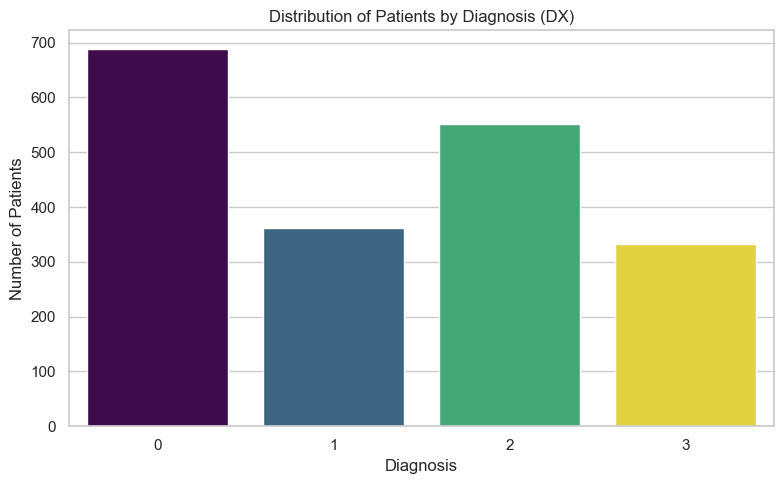

In [17]:
viz = Visualizer(train)
viz.count_plot(
    x="DX",
    figsize=(8, 5),
    palette="viridis",
    order = [0, 1, 2, 3],
    xlabel="Diagnosis",
    ylabel="Number of Patients",
    title="Distribution of Patients by Diagnosis (DX)"
)

We already see that: 
- CN:   689 -> 35.63%
- EMCI: 361 -> 18.67%
- LMCI: 551 -> 28.48%
- AD:   333 -> 17.22%

In [18]:
def fit_evaluate_store_models(X_train, y_train, output_dir='../results/all_models'):
    os.makedirs(output_dir, exist_ok=True)

    # Define classifiers
    classifiers = {
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'Extra Trees': ExtraTreesClassifier(random_state=42, class_weight='balanced'),
        'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
        'AdaBoost': AdaBoostClassifier(random_state=42),
        'Logistic Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('logreg', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
        ]),
        'Bagging': BaggingClassifier(random_state=42)
    }

    # Repeated stratified CV
    cv_splitter = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

    metrics_list = []
    per_class_metrics_list = []
    confusion_dict = {}
    confusion_norm_dict = {}
    roc_dict = {}
    saved_model_paths = {}

    # Container to store per-fold accuracies for each model
    accuracies_per_model = {}

    classes = np.unique(y_train)

    for clf_name, clf_model in classifiers.items():
        print(f"Training & Evaluating: {clf_name}")  # progress indicator

        true_all = []
        pred_all = []
        prob_all_list = []        # Collect per-fold probability arrays (aligned)
        fold_accuracies = []      # Collect per-fold accuracies

        # Cross-validation loop
        for train_idx, val_idx in cv_splitter.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            clf_model.fit(X_train_fold, y_train_fold)
            y_pred = clf_model.predict(X_val_fold)

            # Get probability scores
            y_prob = clf_model.predict_proba(X_val_fold)
            
            # Align probabilities columns to classes
            prob_cols = getattr(clf_model, "classes_", None)

            # Create DataFrame and reindex to global `classes` order
            prob_df = pd.DataFrame(y_prob, columns=prob_cols)

            # Reindex: keep columns in the order of `classes`; missing columns -> filled with 0
            prob_df = prob_df.reindex(columns=classes, fill_value=0)

            # Now append the aligned numpy array
            prob_all_list.append(prob_df.values)

            # Aggregate fold results
            true_all.extend(y_val_fold)
            pred_all.extend(y_pred)

            # Compute fold accuracy
            fold_acc = accuracy_score(y_val_fold, y_pred)
            fold_accuracies.append(fold_acc)

        # Store fold accuracies for violin plot
        accuracies_per_model[clf_name] = fold_accuracies

        # Stack probabilities from all folds
        prob_all = np.vstack(prob_all_list) if len(prob_all_list) > 0 else np.empty((0, len(classes)))

        true_all = np.array(true_all)
        pred_all = np.array(pred_all)

        # Global / weighted metrics
        clf_metrics = {
            'Model': clf_name,
            'Accuracy': accuracy_score(true_all, pred_all),
            'Precision (weighted)': precision_score(true_all, pred_all, average='weighted', zero_division=0),
            'Recall (weighted)': recall_score(true_all, pred_all, average='weighted'),
            'F1 Score (weighted)': f1_score(true_all, pred_all, average='weighted'),
            'ROC AUC (macro)': roc_auc_score(label_binarize(true_all, classes=classes), prob_all, average='macro', multi_class='ovr')
        }
        metrics_list.append(clf_metrics)

        # Per-class metrics
        class_report = classification_report(true_all, pred_all, labels=classes, output_dict=True, zero_division=0)
        for cls in classes:
            rep = class_report.get(str(cls), {})
            per_class_metrics_list.append({
                'Model': clf_name,
                'Class': cls,
                'Precision': rep.get('precision', 0.0),
                'Recall': rep.get('recall', 0.0),
                'F1 Score': rep.get('f1-score', 0.0),
                'Support': rep.get('support', 0)
            })

        # Confusion matrix (counts and normalized)
        cm = confusion_matrix(true_all, pred_all, labels=classes)
        confusion_dict[clf_name] = cm

        row_sums = cm.sum(axis=1, keepdims=True)
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_norm = np.divide(cm, row_sums, where=row_sums != 0)
            cm_norm = np.nan_to_num(cm_norm)
        confusion_norm_dict[clf_name] = cm_norm

        # ROC One-vs-Rest per class
        y_true_bin = label_binarize(true_all, classes=classes)
        fpr_dict = {}
        tpr_dict = {}
        auc_dict = {}
        for i, cls in enumerate(classes):
            if y_true_bin[:, i].sum() == 0:
                fpr_dict[cls] = np.array([0.0, 1.0])
                tpr_dict[cls] = np.array([0.0, 1.0])
                auc_dict[cls] = np.nan
                continue
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], prob_all[:, i])
            auc_val = roc_auc_score(y_true_bin[:, i], prob_all[:, i])
            fpr_dict[cls] = fpr
            tpr_dict[cls] = tpr
            auc_dict[cls] = auc_val
        roc_dict[clf_name] = (fpr_dict, tpr_dict, auc_dict)

        # Refit model on the full training set before saving
        clf_model.fit(X_train, y_train)
        joblib.dump(clf_model, os.path.join(output_dir, f"{clf_name.replace(' ', '_')}.joblib"), compress=3)
        saved_model_paths[clf_name] = os.path.join(output_dir, f"{clf_name.replace(' ', '_')}.joblib")

    # Results DataFrame
    results_df = pd.DataFrame(metrics_list).sort_values('ROC AUC (macro)', ascending=False)
    display(results_df)

    # Per-class metrics DataFrame
    per_class_df = pd.DataFrame(per_class_metrics_list)
    display(per_class_df)

    # Plot ROC curves: one figure per class (all models compared on that class)
    for cls in classes:
        plt.figure(figsize=(8, 6))
        for clf_name, (fpr_dict, tpr_dict, auc_dict) in roc_dict.items():
            auc_val = auc_dict[cls]
            plt.plot(fpr_dict[cls], tpr_dict[cls],
                     label=f'{clf_name} (AUC={auc_val:.2f})' if not np.isnan(auc_val) else f'{clf_name} (AUC=nan)')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Class {cls} (One-vs-Rest)')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

    # Plot confusion matrices (absolute counts)
    n_classifiers = len(confusion_dict)
    n_cols = 4
    n_rows = n_classifiers // n_cols + int(n_classifiers % n_cols > 0)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    for idx, (clf_name, cm) in enumerate(confusion_dict.items()):
        ax = axes[idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f'{clf_name} Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    for idx in range(len(confusion_dict), len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout()
    plt.show()

    # Plot normalized confusion matrices
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    for idx, (clf_name, cm_norm) in enumerate(confusion_norm_dict.items()):
        ax = axes[idx]
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f'{clf_name} Normalized Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    for idx in range(len(confusion_norm_dict), len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout()
    plt.show()

    # Violin plot of per-fold accuracies for each model
    violin_rows = []
    for model_name, acc_list in accuracies_per_model.items():
        for acc in acc_list:
            violin_rows.append({'Model': model_name, 'Accuracy': acc})
    if violin_rows:
        violin_df = pd.DataFrame(violin_rows)
        plt.figure(figsize=(12, 8))
        sns.violinplot(x='Model', y='Accuracy', data=violin_df, inner='quartile')
        plt.xlabel('Model')
        plt.ylabel('Accuracy')
        plt.title('Model Accuracy Comparison (per-fold distributions)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        

In [19]:
def run_gridsearch(X_train, y_train, cv=5, scoring='f1_weighted'):
    """
    Runs GridSearchCV on multiple classifiers with their respective parameter grids.
    The classifiers and parameter grids are predefined inside the function.

    Parameters
    ----------
    X_train : array-like
        Training feature matrix.
    y_train : array-like
        Training target vector.
    cv : int, default=5
        Number of folds for cross-validation.
    scoring : str, default='f1_macro'
        Scoring metric to optimize (e.g., 'accuracy', 'roc_auc', 'f1_macro').

    Returns
    -------
    best_models : dict
        Dictionary containing best estimator, parameters, and score for each classifier.
    """

    # === Classifiers definitions ===
    classifiers = {
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'Extra Trees': ExtraTreesClassifier(random_state=42, class_weight='balanced'),
        'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
        'AdaBoost': AdaBoostClassifier(random_state=42),
        'Logistic Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('logreg', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
        ]),
        'Bagging': BaggingClassifier(random_state=42)
    }

    # === Parameter grids ===
    param_grids = {
        'Random Forest': {
            'n_estimators': [10, 20, 30, 40, 50],
            'max_depth': [None, 10, 6, 4],
            'min_samples_leaf': [1, 5, 10],
            'max_features': ['sqrt', 0.5, 1]
        },
        'Extra Trees': {
            'n_estimators': [10, 20, 30, 40, 50],
            'max_depth': [None, 10, 6, 4],
            'min_samples_leaf': [1, 5, 10],
            'max_features': ['sqrt', 0.5, 1]
        },
        'Decision Tree': {
            'max_depth': [None, 10, 6, 4],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 5, 10]
        },
        'XGBoost': {
            'n_estimators': [10, 20, 30, 40, 50],
            'learning_rate': [0.3, 0.1, 0.05, 0.01],
            'max_depth': [None, 10, 6, 4],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.5, 0.8, 1.0],
            'reg_alpha': [0, 1],
            'reg_lambda': [0, 1]
        },
        'LightGBM': {
            'n_estimators': [10, 20, 30, 40, 50],
            'learning_rate': [0.3, 0.1, 0.05, 0.01],
            'max_depth': [None, 10, 6, 4],
            'min_child_samples': [5, 20, 50],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.5, 0.8, 1.0],
            'reg_alpha': [0, 1],
            'reg_lambda': [0, 1]
        },
        'AdaBoost': {
            'n_estimators': [10, 20, 30, 40, 50],
            'learning_rate': [1.0, 0.5, 0.1],
        },
        'Logistic Regression': {
            'logreg__C': [0.01, 0.1, 1.0, 10.0],
            'logreg__penalty': ['l2']
        },
        'Bagging': {
            'n_estimators': [10, 20, 30, 40, 50],
            'max_samples': [0.8, 1.0],
            'max_features': [0.5, 0.8, 1.0]
        }
    }

    # === Run GridSearch for each classifier ===
    best_models = {}

    for name, clf in classifiers.items():
        print(f"\nRunning GridSearch for {name} ...")
        param_grid = param_grids[name]

        # Define GridSearchCV
        grid = GridSearchCV(
            estimator=clf,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,    # Use all available CPU cores
            verbose=1
        )

        # Fit on training data
        grid.fit(X_train, y_train)

        # Store results
        best_models[name] = {
            "best_estimator": grid.best_estimator_,
            "best_params": grid.best_params_,
            "best_score": grid.best_score_
        }

        # Print best params and score
        print(f"Best params for {name}: {grid.best_params_}")
        print(f"Best {scoring}: {grid.best_score_:.4f}")

    return best_models

In [20]:
# train = pd.read_csv("../data/gg.csv")
# train.drop(["PTETHNICITY", "Hippocampus", "Entorhinal", "Fusiform", "MidTemp", "Ventricles", "WholeBrain", "ICV", "RAVLT_forgetting", "ABETA", "PTAU", "TAU"], axis=1, inplace=True)
train.drop(columns=['CDRSB', 'LDELTOTAL', 'mPACCdigit'], axis=1, inplace=True)
test.drop(columns=['CDRSB', 'LDELTOTAL', 'mPACCdigit'], axis=1, inplace=True)

# Target column
y_train = train['DX']

# All other columns as features
X_train = train.drop(columns=['DX'])

run_gridsearch(X_train, y_train)


Running GridSearch for Random Forest ...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best params for Random Forest: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 10, 'n_estimators': 20}
Best f1_weighted: 0.7489

Running GridSearch for Extra Trees ...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best params for Extra Trees: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 40}
Best f1_weighted: 0.7340

Running GridSearch for Decision Tree ...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params for Decision Tree: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best f1_weighted: 0.6978

Running GridSearch for XGBoost ...
Fitting 5 folds for each of 1920 candidates, totalling 9600 fits
Best params for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 0.8}
Best f1_weighted: 0.7461

Run

{'Random Forest': {'best_estimator': RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.5,
                         min_samples_leaf=10, n_estimators=20, random_state=42),
  'best_params': {'max_depth': 10,
   'max_features': 0.5,
   'min_samples_leaf': 10,
   'n_estimators': 20},
  'best_score': np.float64(0.748851067611455)},
 'Extra Trees': {'best_estimator': ExtraTreesClassifier(class_weight='balanced', max_depth=10, max_features=0.5,
                       min_samples_leaf=5, n_estimators=40, random_state=42),
  'best_params': {'max_depth': 10,
   'max_features': 0.5,
   'min_samples_leaf': 5,
   'n_estimators': 40},
  'best_score': np.float64(0.7340070428230571)},
 'Decision Tree': {'best_estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=5,
                         random_state=42),
  'best_params': {'max_depth': 4,
   'min_samples_leaf': 5,
   'min_samples_split': 2},
  'best_score': np.float64(0.6977906522178418)